# GSE176078 SHAP Analysis

## Imports

In [1]:
# Necessary imports for the notebook. Please ensure these libraries are installed in your Python environment
# If not then please install them using the requirements.txt file.
import os
os.environ["SCIPY_ARRAY_API"] = "1"
import numpy as np
import pandas as pd
import joblib
from xgboost import XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from imblearn.over_sampling import SMOTE

a:\Capstone Local-GIt\ghost-cell-busters\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# This is the relative path of the assets directory, if the assets are in another location please change the path accordingly.
assets = "../assets"

In [3]:
X_train = pd.read_csv(f"{assets}/GSE176078/GSE176078_X_train.csv")
X_test = pd.read_csv(f"{assets}/GSE176078/GSE176078_X_test.csv")
y_train = pd.read_csv(f"{assets}/GSE176078/GSE176078_y_train.csv")
y_test = pd.read_csv(f"{assets}/GSE176078/GSE176078_y_test.csv")

In [4]:
# Load the model from the specified path
model = joblib.load(f"{assets}/GSE176078/GSE176078_xgboost_model.pkl")

Feature 1: apoptosis_score 
 	Gain: 110.78868865966797
Feature 2: oxphos_score 
 	Gain: 59.02289962768555
Feature 3: pct_counts_ribo 
 	Gain: 88.08683013916016
Feature 4: nCount_RNA 
 	Gain: 28.686920166015625
Feature 5: cnv_score 
 	Gain: 53.54074478149414
Feature 6: S_score 
 	Gain: 67.60212707519531
Feature 7: G2M_score 
 	Gain: 44.691341400146484
Feature 8: percent.mito 
 	Gain: 60.72289276123047


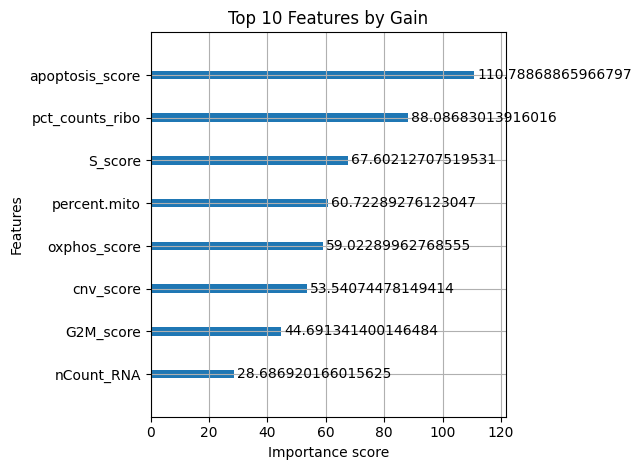

In [5]:
# This returns a Booster object
booster = model.get_booster()

# Get feature importance by 'gain'
importance = booster.get_score(importance_type='gain')
for i, imp in enumerate(importance.items()):
    print(f"Feature {i+1}: {imp[0]} \n \tGain: {imp[1]}")

# Plot top 10 features by gain
plot_importance(model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Features by Gain")
plt.tight_layout()
plt.show()

In [6]:
# Compare Gain, Cover, and Weight

# Collect importances
importance_types = ["weight", "gain", "cover"]
importance_dfs = []

for imp_type in importance_types:
    scores = booster.get_score(importance_type=imp_type)
    df = pd.DataFrame.from_dict(scores, orient="index", columns=[imp_type])
    importance_dfs.append(df)

# Merge all importance types into one DataFrame
importance_all = pd.concat(importance_dfs, axis=1).fillna(0)
importance_all.index.name = "feature"
importance_all = importance_all.reset_index()

# Normalize each column for comparison
for imp_type in importance_types:
    max_val = importance_all[imp_type].max()
    if max_val > 0:
        importance_all[imp_type] /= max_val

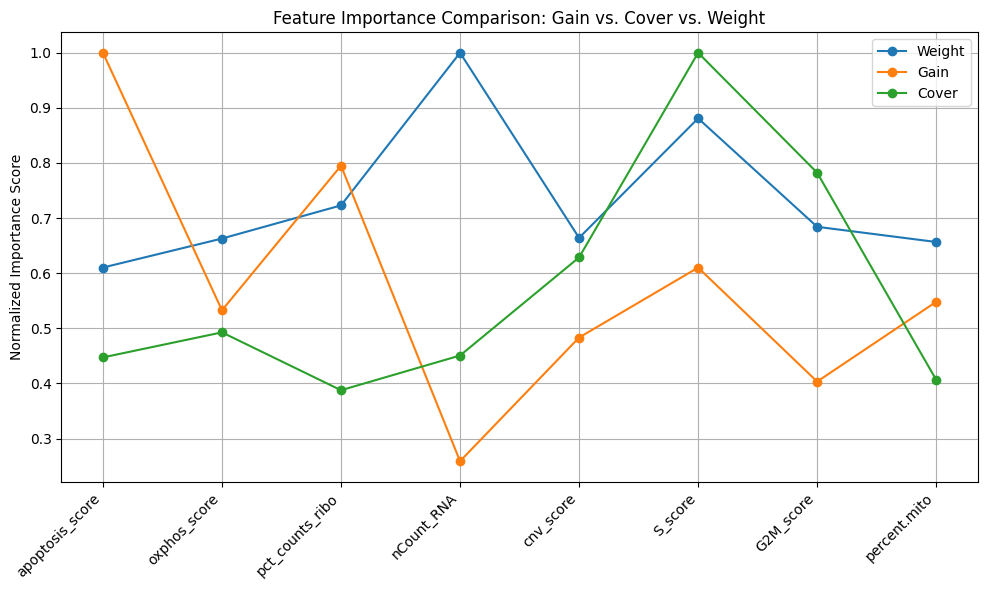

In [7]:
# Plot
plt.figure(figsize=(10, 6))
for imp_type in importance_types:
    plt.plot(
        importance_all["feature"],
        importance_all[imp_type],
        marker='o',
        label=imp_type.capitalize()
    )

plt.xticks(rotation=45, ha='right')
plt.ylabel("Normalized Importance Score")
plt.title("Feature Importance Comparison: Gain vs. Cover vs. Weight")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

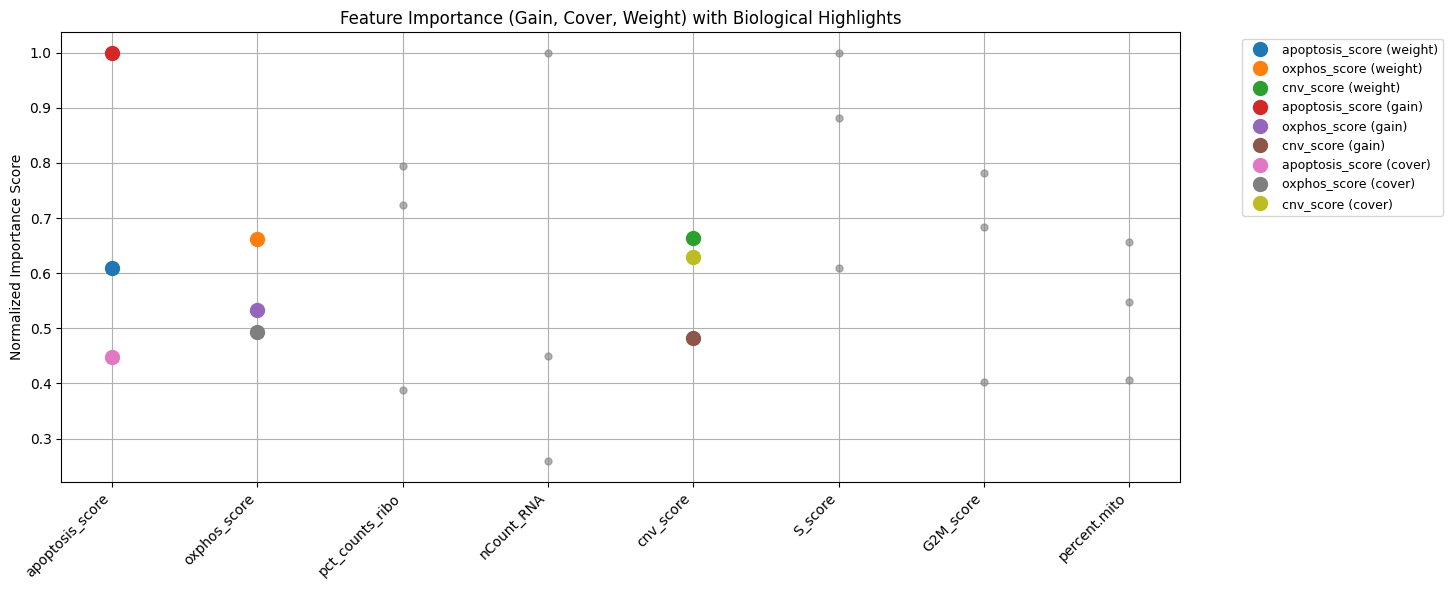

In [8]:
# Biologically relevant features to highlight
biologically_relevant = ["cnv_score", "proto_oncogenescore", "apoptosis_score", "oxphos_score"]

# Plot
plt.figure(figsize=(12, 6))

for imp_type in importance_types:
    for i, row in importance_all.iterrows():
        if row["feature"] in biologically_relevant:
            plt.plot(
                row["feature"], row[imp_type],
                marker='o', markersize=10, label=f"{row['feature']} ({imp_type})",
                linestyle='None'
            )
        else:
            plt.plot(
                row["feature"], row[imp_type],
                marker='o', markersize=5, color='gray',
                linestyle='None', alpha=0.6
            )

plt.xticks(rotation=45, ha='right')
plt.ylabel("Normalized Importance Score")
plt.title("Feature Importance (Gain, Cover, Weight) with Biological Highlights")
plt.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.show()

In [9]:
importance_all.set_index("feature")

,weight,gain,cover
feature,,,
apoptosis_score,0.610276,1.000000,0.447251
oxphos_score,0.662907,0.532752,0.492674
pct_counts_ribo,0.723058,0.795089,0.387704
nCount_RNA,1.000000,0.258934,0.450657
cnv_score,0.664160,0.483269,0.628639
S_score,0.880952,0.610190,1.000000
G2M_score,0.684211,0.403393,0.782351
percent.mito,0.656642,0.548097,0.406639


In [10]:
# SMOTE for balanced training.
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print("SMOTE applied:\n X_train_sm shape:", X_train_sm.shape, "y_train_sm shape:", y_train_sm.shape)

SMOTE applied:
 X_train_sm shape: (153134, 9) y_train_sm shape: (153134, 1)


100%|===================| 153080/153134 [10:35<00:00]        

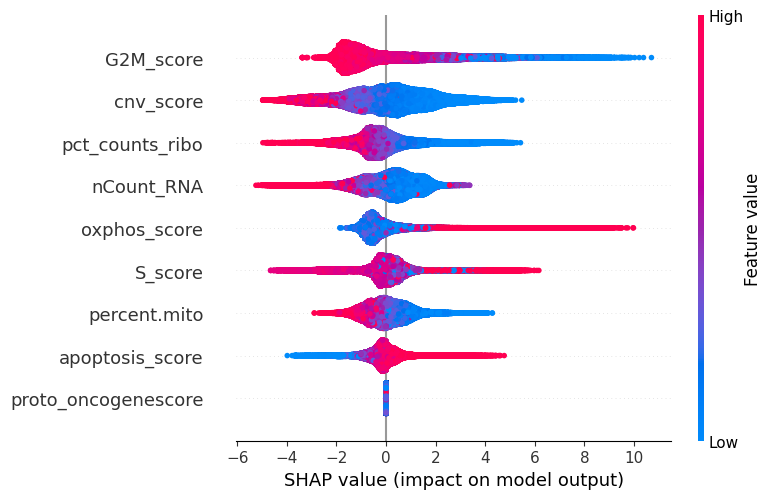

In [11]:
# Defining top features.
top_features = [
    "apoptosis_score", "oxphos_score",
    "pct_counts_ribo", "nCount_RNA", "cnv_score",
    "proto_oncogenescore", "S_score", "G2M_score","percent.mito"
]

# Initialize SHAP explainer
explainer = shap.Explainer(model, X_train_sm)

# Compute SHAP values
shap_values_x_train = explainer(X_train_sm)

# SHAP summary plot
shap.summary_plot(shap_values_x_train, features=X_train_sm, feature_names=top_features, show=True)

In [28]:
# SHAP explainer and values
# shap_values_x_test = explainer.shap_values(X_test)
shap_values_x_test = explainer(X_test)

# Compute mean absolute SHAP value per feature
shap_importance = np.abs(shap_values_x_test.values).mean(axis=0)
shap_df = pd.DataFrame({
    "feature": X_test.columns,
    "shap_importance": shap_importance
})

# Merge with SHAP importance (also normalized)
shap_df["shap_importance"] /= shap_df["shap_importance"].max()
merged_df = pd.merge(importance_all, shap_df, on="feature", how="outer").fillna(0)
melted_df = merged_df.melt(id_vars="feature",
                            value_vars=["weight", "gain", "cover", "shap_importance"],
                            var_name="metric", value_name="importance")

100%|===================| 19987/20013 [01:11<00:00]        

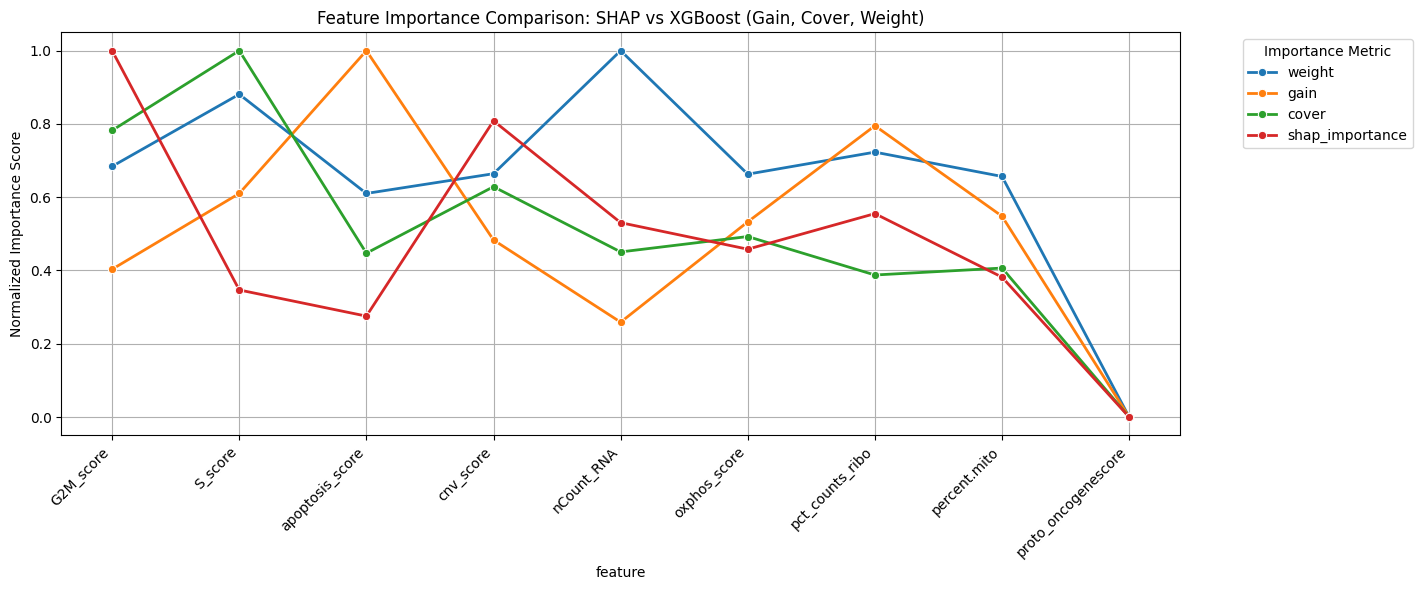

In [14]:
# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=melted_df,
    x="feature", y="importance", hue="metric",
    marker='o', linewidth=2
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Normalized Importance Score")
plt.title("Feature Importance Comparison: SHAP vs XGBoost (Gain, Cover, Weight)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Importance Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

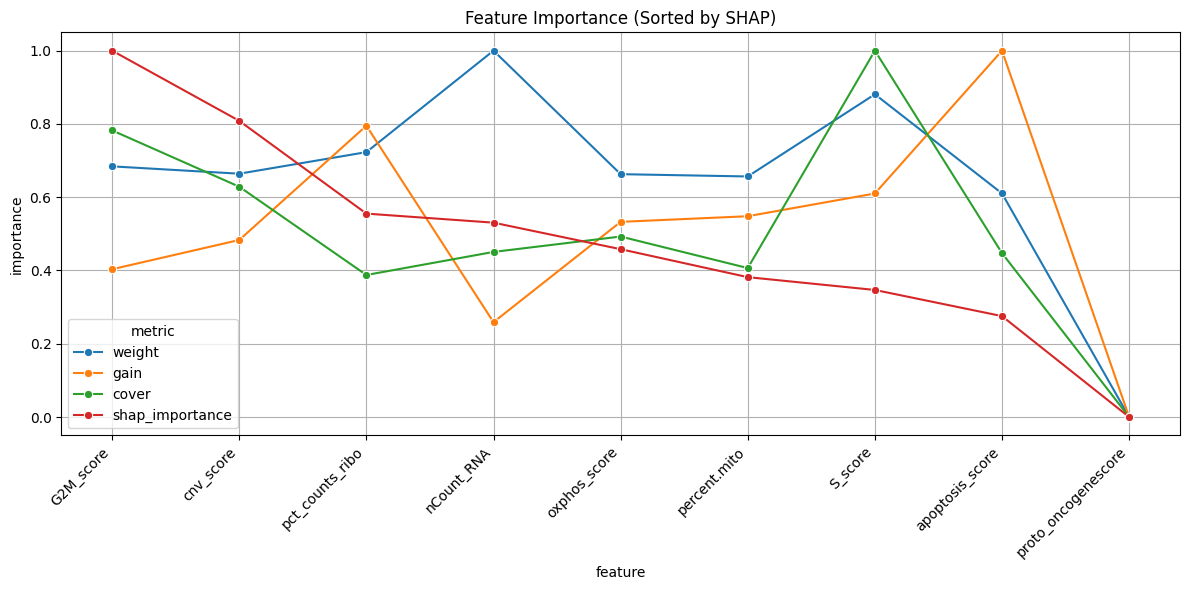

In [15]:
# Sort by SHAP importance for better visibility
# Sort by SHAP importance to emphasize most influential features.
melted_df_sorted = melted_df.copy()
shap_order = merged_df.sort_values("shap_importance", ascending=False)["feature"]
melted_df_sorted["feature"] = pd.Categorical(melted_df_sorted["feature"], categories=shap_order, ordered=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_df_sorted, x="feature", y="importance", hue="metric", marker="o")
plt.xticks(rotation=45, ha='right')
plt.title("Feature Importance (Sorted by SHAP)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Gain vs SHAP Importance (Sorted by SHAP)
# Keep only gain and SHAP columns
gain_shap_df = merged_df[["feature", "gain", "shap_importance"]].copy()

# Melt to long format for plotting
melted_gain_shap = gain_shap_df.melt(id_vars="feature",
                                    value_vars=["gain", "shap_importance"],
                                    var_name="metric", value_name="importance")

# Sort features by SHAP importance for axis order
shap_order = gain_shap_df.sort_values("shap_importance", ascending=False)["feature"]
melted_gain_shap["feature"] = pd.Categorical(melted_gain_shap["feature"],
                                            categories=shap_order, ordered=True)

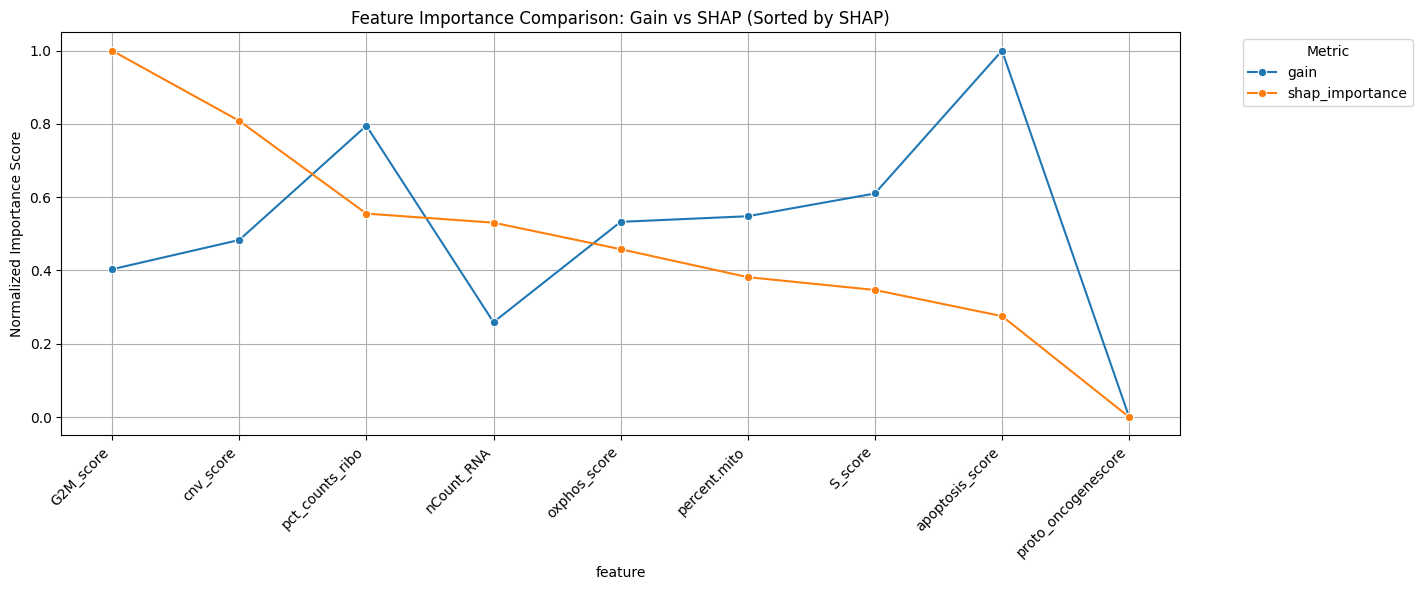

In [17]:
# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_gain_shap, x="feature", y="importance", hue="metric", marker="o")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Normalized Importance Score")
plt.title("Feature Importance Comparison: Gain vs SHAP (Sorted by SHAP)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

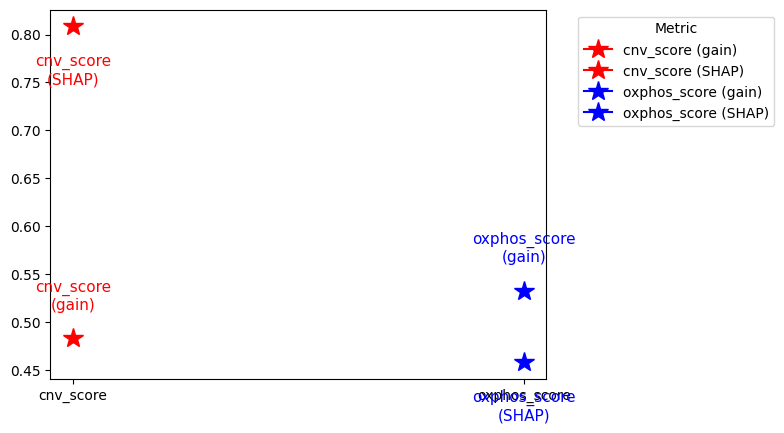

In [18]:
# # Highlight cnv_score with a red star
# cnv_x = "cnv_score"
# cnv_gain = gain_shap_df.loc[gain_shap_df["feature"] == cnv_x, "gain"].values[0]
# cnv_shap = gain_shap_df.loc[gain_shap_df["feature"] == cnv_x, "shap_importance"].values[0]

# # Plot the star marker
# plt.plot(cnv_x, cnv_gain, marker='*', color='red', markersize=15, label='cnv_score (gain)')
# plt.plot(cnv_x, cnv_shap, marker='*', color='darkred', markersize=15, label='cnv_score (SHAP)')

# # Optional: prevent legend duplication
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Metric")

# List of features to highlight
highlight_features = ["cnv_score", "oxphos_score"]
colors = ["red", "blue"]  # Different colors for each
labels = ["cnv_score", "oxphos_score"]

for feat, color, label in zip(highlight_features, colors, labels):
    # Get gain and SHAP values
    gain_val = gain_shap_df.loc[gain_shap_df["feature"] == feat, "gain"].values[0]
    shap_val = gain_shap_df.loc[gain_shap_df["feature"] == feat, "shap_importance"].values[0]

    # Plot stars
    plt.plot(feat, gain_val, marker='*', color=color, markersize=15, label=f'{label} (gain)')
    #plt.plot(feat, shap_val, marker='*', color=color, markersize=15, markeredgecolor='green', label=f'{label} (SHAP)')
    plt.plot(feat, shap_val, marker='*', color=color, markersize=15, label=f'{label} (SHAP)')

    # Annotate points
    plt.text(feat, gain_val + 0.03, f"{label}\n(gain)", color=color, fontsize=11, ha='center')
    plt.text(feat, shap_val - 0.06, f"{label}\n(SHAP)", color=color, fontsize=11, ha='center')

# Deduplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Metric")

In [ ]:
# shap_values_x_test = explainer(X_test)

 99%|===================| 19910/20013 [01:16<00:00]        

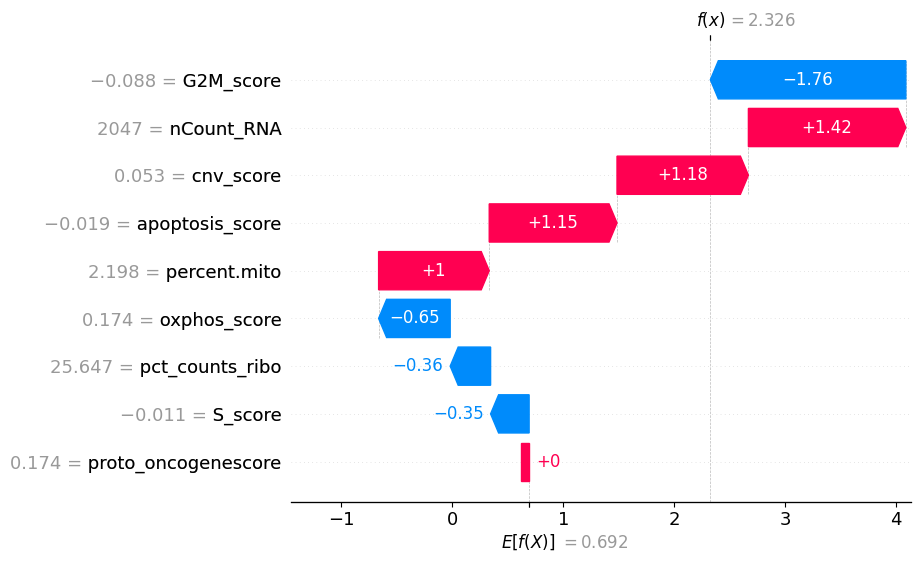

In [24]:
shap.plots.waterfall(shap_values_x_test[5])

In [25]:
# SHAP waterfall plot for one tumor-predicted cell and one for a normal-predicted cell
# Assuming threshold of 0.5 for tumor vs normal
y_pred = model.predict(X_test)
pred_labels = (y_pred > 0.5).astype(int)

# Find index of one tumor cell and one normal cell
tumor_idx = np.where(pred_labels == 1)[0][0]
normal_idx = np.where(pred_labels == 0)[0][0]

# Print confirmation
print(f"Tumor cell at index: {tumor_idx}")
print(f"Normal cell at index: {normal_idx}")

Tumor cell at index: 0
Normal cell at index: 19


Tumor Cell SHAP Waterfall


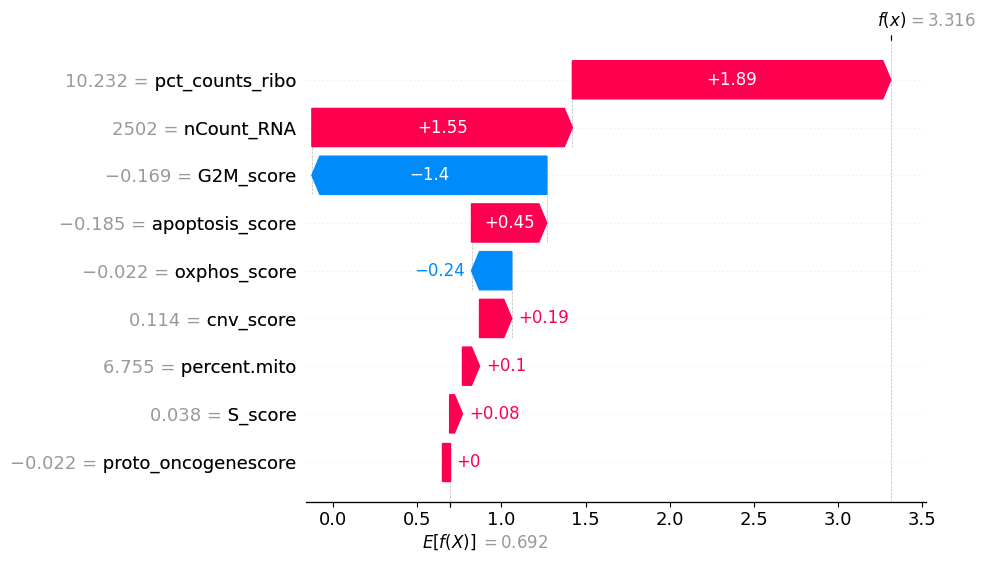

In [26]:
# Waterfall plot for tumor cell
print("Tumor Cell SHAP Waterfall")
shap.plots.waterfall(shap_values_x_test[tumor_idx], max_display=10)

Normal Cell SHAP Waterfall


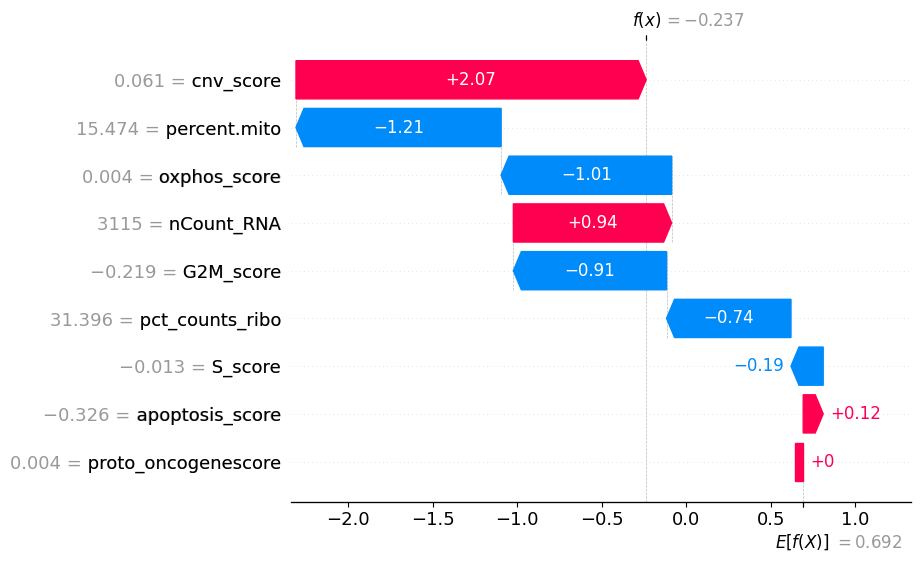

In [27]:
# Waterfall plot for normal cell
print("Normal Cell SHAP Waterfall")
shap.plots.waterfall(shap_values_x_test[normal_idx], max_display=10)